In [28]:



%load_ext autoreload
%autoreload 2
base = '/home3/ebrahim2/beyond-brainscore/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import sys
sys.path.append(base)
from plotting_functions import plot_across_subjects, plot_test_perf_across_layers, save_fMRI_simple, pass_info_plot_hist2d, find_rows_without_nan
from trained_results_funcs import create_pd_selected_models, find_best, max_across_selected_models
from trained_untrained_results_funcs import max_across_nested
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd
import matplotlib
from scipy.stats import ttest_rel, ttest_1samp
import nibabel as nib
from nilearn import plotting
from nilearn import surface
from nilearn import datasets

In [32]:
def find_best_sigma(sigma_range, noL2_str, exp, resultsPath, dataset, subjects, perf='pearson_r',
                    lang_indices=None):
    
    '''
    Finds best sigma value for OASM by taking the mean/median across subjects, and then taking 
    the mean across subjects.
    '''

    sigma_perf_dict = {}
    
    if dataset == 'pereira':
        subjects = subjects[lang_indices]
    
    for s in sigma_range:
        
        s = round(s,3)
        
        # load in performance of OASM across voxels/electrodes/ROIs
        OASM_perf =  np.load(f'{resultsPath}/{dataset}_OASM-all-sigma_{s}_1{noL2_str}{exp}.npz')[perf]
        
        OASM_perf = np.nan_to_num(OASM_perf, 0)
    
        
        # if pereira, take median across language network voxels
        # otherwise simply take the median
        if dataset == 'pereira':
            OASM_perf = OASM_perf[lang_indices]
            
            
        OASM_subj = pd.DataFrame({'perf': OASM_perf, 'subject': subjects})
        
        if perf == 'pearson_r':
            perf_avg = np.median(OASM_subj.groupby(['subject']).median())
        else:
            perf_avg = np.mean(OASM_subj.groupby(['subject']).mean())
    
        # make sure it's not nan, happens sometimes when sigma is low 
        # not totally sure why 
        if ~np.isnan(perf_avg):
            sigma_perf_dict[s] = perf_avg
        
    best_sigma = max(sigma_perf_dict, key=sigma_perf_dict.get)
    
    OASM_perf_best =  np.load(f'{resultsPath}/{dataset}_OASM-all-sigma_{best_sigma}_1{noL2_str}{exp}.npz')[perf]
    OASM_perf_best = np.nan_to_num(OASM_perf_best, 0)
        
    return sigma_perf_dict, best_sigma, OASM_perf_best

def find_best_layer(layer_range, noL2_str, exp, resultsPath, subjects, dataset, perf='pearson_r', 
                    lang_indices = None):
    

    layer_perf_dict = {}
    
    if dataset == 'pereira':
        subjects = subjects[lang_indices]
    
    for l in layer_range:
    
        layer_perf =  np.load(f'{resultsPath}/{dataset}_gpt2-xl_layer_{l}_1{noL2_str}{exp}.npz')[perf]
        
        if perf != 'pearson_r':
            layer_perf = np.clip(layer_perf, 0, np.inf)
        
        layer_perf = np.nan_to_num(layer_perf, nan=0)
        
        if dataset == 'pereira':
            layer_perf = layer_perf[lang_indices]
            
            
        layer_subject = pd.DataFrame({'perf': layer_perf, 'subject': subjects})    
    
        if perf == 'pearson_r':
            perf_avg = np.median(layer_subject.groupby(['subject']).median())
        else:
            perf_avg = np.mean(layer_subject.groupby(['subject']).mean())
        
        layer_perf_dict[l] = perf_avg
            
    best_layer = max(layer_perf_dict, key=layer_perf_dict.get)
    
    layer_perf_best =  np.load(f'{resultsPath}/{dataset}_gpt2-xl_layer_{best_layer}_1{noL2_str}{exp}.npz')[perf]
    layer_perf_best = np.nan_to_num(layer_perf_best, 0)
        
    return layer_perf_dict, best_layer, layer_perf_best    

noL2_arr = [False]
shuffled_arr = [True]
dataset_arr = ['pereira']
perf_arr = ['pearson_r']

for perf in perf_arr:
    for noL2 in noL2_arr:
        for shuffled in shuffled_arr:
            for dataset in dataset_arr:
                
                if noL2:
                    noL2_str = '_noL2'
                else:
                    noL2_str = ''
                    
                if shuffled:
                    shuffled_str = '_shuffled'
                else:
                    shuffled_str = ''

                
                resultsPath_dataset_nonshuffled = f'/data/LLMs/brainscore/results_{dataset}'
                
                if shuffled:
                    resultsPath_dataset = f'/data/LLMs/brainscore/results_{dataset}/shuffled'
                else:
                    resultsPath_dataset = resultsPath_dataset_nonshuffled
                    
                data_processed_folder = f'/data/LLMs/data_processed/{dataset}/dataset'
                figurePath = '/home3/ebrahim2/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure1/'
                figurePath = f'{figurePath}{perf}/'
                default_palette = sns.color_palette('deep')   

        
                # load information regarding number of voxels, subjects, and functional network localization for each experiment into a dictionary
                if dataset ==  'pereira':

                    exp = ['243', '384']

                    br_labels_dict = {}
                    num_vox_dict = {}
                    subjects_dict = {}
                    for e in exp:

                        bre = np.load(f'{data_processed_folder}/networks_{e}.npy', allow_pickle=True)
                        br_labels_dict[e] = bre
                        num_vox_dict[e] = bre.shape[0]
                        subjects_dict[e] = np.load(f"{data_processed_folder}/subjects_{e}.npy", allow_pickle=True)
                        
                    lang_indices_384 = np.argwhere(br_labels_dict['384'] == 'language').squeeze()
                    lang_indices_243 = np.argwhere(br_labels_dict['243'] == 'language').squeeze()
                    
                else:
                    subjects_arr  = np.load(f"{data_processed_folder}/subjects.npy", allow_pickle=True)
                    

                if shuffled:
                    # script crashes at sigma of 4.3 in fed due to an issue with linear reg converging
                    if dataset == 'fedorenko' and shuffled:
                        sigma_values = np.linspace(0.1, 4.2, 42)
                    else:
                        sigma_values = np.linspace(0.1, 4.8, 48)
                                
                    if dataset == 'pereira':
                        sigma_perf_dict_384, best_sigma_384, OASM_perf_best_sigma_384 = find_best_sigma(sigma_values, noL2_str=noL2_str, exp='_384', subjects=subjects_dict['384'], 
                                                                        resultsPath=resultsPath_dataset, dataset=dataset, lang_indices=lang_indices_384, 
                                                                        perf=perf)   
                        sigma_perf_dict_243, best_sigma_243, OASM_perf_best_sigma_243 = find_best_sigma(sigma_values, noL2_str=noL2_str, exp='_243', subjects=subjects_dict['243'], 
                                                                        resultsPath=resultsPath_dataset, dataset=dataset, lang_indices=lang_indices_243, 
                                                                        perf=perf)
                    else:
                        sigma_perf_dict, best_sigma, OASM_perf_best_sigma = find_best_sigma(sigma_values, noL2_str=noL2_str, exp='', subjects=subjects_arr, resultsPath=resultsPath_dataset, dataset=dataset, perf=perf)
                        
                    if dataset == 'pereira':
                        plt.plot(sigma_perf_dict_384.keys(), sigma_perf_dict_384.values(), label='384')
                        plt.plot(sigma_perf_dict_243.keys(), sigma_perf_dict_243.values(), label='243')
                    else:
                        plt.plot(sigma_perf_dict.keys(), sigma_perf_dict.values())
                        
                    plt.legend()
                    plt.xlabel("Sigma values")
                    plt.ylabel("Median pearson r across language voxels")
                    plt.savefig(f"{figurePath}across_layer/across_layer_OASM_{dataset}{noL2_str}{shuffled_str}")
                    plt.close()
                
                else:
                    
                    if dataset == 'pereira':
                        
                        simple_perf_384 =  np.load(f'{resultsPath_dataset}/{dataset}_positional_WN_layer1_1{noL2_str}_384.npz')[perf]
                        simple_perf_243 =  np.load(f'{resultsPath_dataset}/{dataset}_positional_WN_layer1_1{noL2_str}_243.npz')[perf]
                        
                    if dataset == 'fedorenko':
        
                        simple_perf =  np.load(f'{resultsPath_dataset}/{dataset}_soft+grow_layer1_1{noL2_str}.npz')[perf]
                        
                
                if dataset == 'pereira':
                    gpt2_xl_384_dict, gpt2_xl_384_bl, gpt2_xl_384_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_384', 
                                                                                            resultsPath=resultsPath_dataset, lang_indices=lang_indices_384, dataset=dataset, 
                                                                                            subjects=subjects_dict['384'], perf=perf)
                    gpt2_xl_243_dict, gpt2_xl_243_bl, gpt2_xl_243_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_243', 
                                                                                            resultsPath=resultsPath_dataset, lang_indices=lang_indices_243, dataset=dataset, 
                                                                                            subjects=subjects_dict['243'], perf=perf)
                else:
                    gpt2_xl_dict, gpt2_xl_bl, gpt2_xl_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='', subjects=subjects_arr, resultsPath=resultsPath_dataset, dataset=dataset, perf=perf)

                
                if dataset == 'pereira':
                    plt.plot(gpt2_xl_384_dict.keys(), gpt2_xl_384_dict.values(), label='384')
                    plt.plot(gpt2_xl_243_dict.keys(), gpt2_xl_243_dict.values(), label='243')
                else:
                    plt.plot(gpt2_xl_dict.keys(), gpt2_xl_dict.values())
                plt.legend()
                plt.xlabel("Layer number")
                plt.ylabel("Median pearson r across language voxels")
                plt.savefig(f"{figurePath}across_layer/across_layer_GPT2XL_{dataset}{noL2_str}{shuffled_str}")
                plt.close()
                
        
                if dataset == 'pereira':
                    
                    if shuffled:
                        results_dict_simple_384 = pd.DataFrame({'perf': OASM_perf_best_sigma_384, 'subjects': subjects_dict['384'], 
                                        'Network': br_labels_dict['384'], 'Model': np.repeat('OASM', num_vox_dict['384'])})
                        results_dict_simple_243 = pd.DataFrame({'perf': OASM_perf_best_sigma_243, 'subjects': subjects_dict['243'], 
                                        'Network': br_labels_dict['243'], 'Model': np.repeat('OASM', num_vox_dict['243'])})
                        
                    else:
                        results_dict_simple_384 = pd.DataFrame({'perf': simple_perf_384, 'subjects': subjects_dict['384'], 
                                        'Network': br_labels_dict['384'], 'Model': np.repeat('SP+SL', num_vox_dict['384'])})
                        results_dict_simple_243 = pd.DataFrame({'perf': simple_perf_243, 'subjects': subjects_dict['243'], 
                                        'Network': br_labels_dict['243'], 'Model': np.repeat('SP+SL', num_vox_dict['243'])})
                        
                    results_dict_gpt2_384 = pd.DataFrame({'perf': gpt2_xl_384_bl_perf, 'subjects': subjects_dict['384'], 
                                    'Network': br_labels_dict['384'], 'Model': np.repeat('GPT2-XL', num_vox_dict['384'])})
                    results_dict_gpt2_243 = pd.DataFrame({'perf': gpt2_xl_243_bl_perf, 'subjects': subjects_dict['243'], 
                                    'Network': br_labels_dict['243'], 'Model': np.repeat('GPT2-XL', num_vox_dict['243'])})

                    results_simple_gpt2xl_243 = pd.concat((results_dict_simple_243, results_dict_gpt2_243))
                    results_simple_gpt2xl_384 = pd.concat((results_dict_simple_384, results_dict_gpt2_384))
                    
                else:
                    num_brain_units = gpt2_xl_bl_perf.shape[0]
                    
                    if shuffled:
                        results_dict_simple = pd.DataFrame({'perf': OASM_perf_best_sigma, 'subjects': subjects_arr, 'Network': np.repeat('language', num_brain_units),
                                                    'Model': np.repeat('OASM', num_brain_units)})
                    else:
                        
                        if dataset == 'fedorenko':
                            results_dict_simple = pd.DataFrame({'perf': simple_perf, 'subjects': subjects_arr, 'Network': np.repeat('language', num_brain_units),
                                                    'Model': np.repeat('WP', num_brain_units)})

                    results_dict_gpt2 = pd.DataFrame({'perf': gpt2_xl_bl_perf, 'subjects': subjects_arr, 'Network': np.repeat('language', num_brain_units),
                                                    'Model': np.repeat('GPT2-XL', num_brain_units)})
                    
                    if shuffled or dataset == 'fedorenko':
                        results_simple_gpt2xl = pd.concat((results_dict_simple, results_dict_gpt2))
                    
                
                if perf == 'pearson_r':
                    median = True
                    clip_zero = False
                    perf_str = 'Pearson r'
                else:
                    median = False
                    clip_zero = True
                    perf_str = r'$R^2$'
                    
                if shuffled:
                    cidx_p = 9
                    cidx_fb = 9
                else:
                    cidx_p = 7
                    cidx_fb = 6
                    
            
        

TypeError: 'method' object is not subscriptable

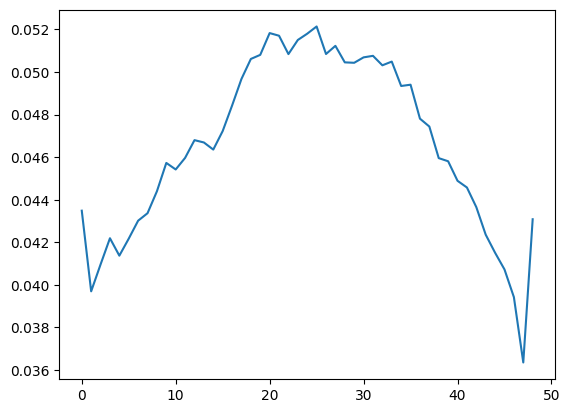

In [16]:
plt.plot(gpt2_xl_dict.keys(), gpt2_xl_dict.values())